In [1]:
# Personal 
from data.TrajectorySet import TrajectorySet
from data.Sampler import Sampler 
from data.DatasetCL import DatasetCL 
from models.cl_model import mlpCL
from trainer.cl_trainer import train_cl
from utils.visualizations import visualize_embeddings

# Misc
import minari 
import os

# Torch 
import torch 

# PyTorch Lightning 
import pytorch_lightning
from pytorch_lightning.loggers import WandbLogger

In [2]:
MINARI_DATASET = minari.load_dataset("D4RL/pointmaze/large-v2")
PROJECT_ROOT = os.getcwd() 
CHECKPOINT_PATH = PROJECT_ROOT + "/saved_models"

PROJECT_NAME = "Contrastive Learning RL"
RUN_NAME = "test-run-20"

CONFIG = {
        "distribution": "g",
        "batch_size": 256,
        "k": 2,
        "lr": 5e-4,
        "weight_decay": 1e-4, 
        "temperature": 0.08,
        "max_epochs": 20,
        "device": "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
    }

In [3]:
wandb_logger = WandbLogger(
        project=PROJECT_NAME, 
        name=RUN_NAME, 
        save_dir = PROJECT_ROOT, 
        log_model=True,
        config = CONFIG) 

dist = CONFIG["distribution"]
batch_size = CONFIG["batch_size"]
k = CONFIG["k"]
lr = CONFIG["lr"]
weight_decay = CONFIG["weight_decay"]
temperature = CONFIG["temperature"]
max_epochs = CONFIG["max_epochs"]
device = CONFIG["device"]

T = TrajectorySet(dataset=MINARI_DATASET)
S = Sampler(T, dist=dist)
train_dataset = DatasetCL(S, batch_size=batch_size, k=k)

val_dataset = DatasetCL(S, batch_size=batch_size, k=k)

In [4]:
model = train_cl(cl_model=mlpCL, 
                train_ds=train_dataset, 
                val_ds=val_dataset, 
                batch_size=batch_size,
                logger=wandb_logger, 
                checkpoint_path=CHECKPOINT_PATH,
                max_epochs=max_epochs, 
                device = device, 
                lr=lr, 
                temperature=temperature, 
                weight_decay = weight_decay)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 10
/Users/ray/Documents/Research Assistancy UofA 2025/Reproduce CL/contrastive-learning-RL/CL_RL/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Currently logged in as: ray-s (ray-s-university-of-alberta) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/Users/ray/Documents/Research Assistancy UofA 2025/Reproduce CL/contrastive-learning-RL/CL_RL/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/ray/Documents/Research Assistancy UofA 2025/Reproduce CL/contrastive-learning-RL/saved_models exists and is not empty.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | mlp  | Sequential | 44.5 K | train
--------------------------------------------
44.5 K    Trainable params
0         Non-trainable params
44.5 K    Total params
0.178     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/ray/Documents/Research Assistancy UofA 2025/Reproduce CL/contrastive-learning-RL/CL_RL/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/ray/Documents/Research Assistancy UofA 2025/Reproduce CL/contrastive-learning-RL/CL_RL/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/ray/Documents/Research Assistancy UofA 2025/Reproduce CL/contrastive-learning-RL/CL_RL/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 40.38it/s, v_num=eqik, train/nll_loss_step=3.190, train/top1_step=0.215, train/top5_step=0.506, val/nll_loss=3.440, val/top1=0.166, val/top5=0.443, train/nll_loss_epoch=3.190, train/top1_epoch=0.215, train/top5_epoch=0.506] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 36.20it/s, v_num=eqik, train/nll_loss_step=3.190, train/top1_step=0.215, train/top5_step=0.506, val/nll_loss=3.440, val/top1=0.166, val/top5=0.443, train/nll_loss_epoch=3.190, train/top1_epoch=0.215, train/top5_epoch=0.506]
Best model path: /Users/ray/Documents/Research Assistancy UofA 2025/Reproduce CL/contrastive-learning-RL/saved_models/best_model-v11.ckpt


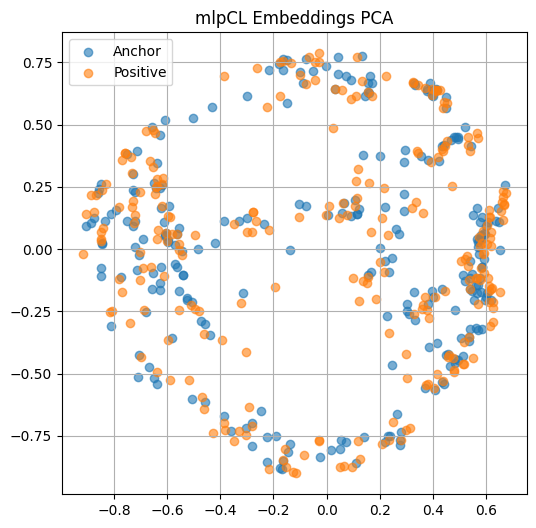

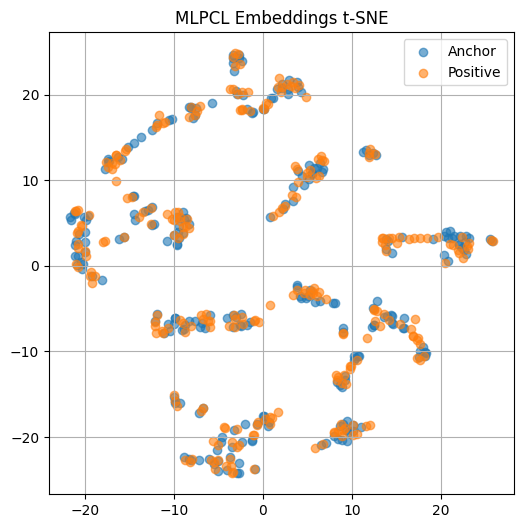

In [5]:
model.eval() 
val_loader = torch.utils.data.DataLoader(dataset= val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
z = model.get_embeddings(val_loader)
visualize_embeddings(z, method="pca", title="mlpCL Embeddings PCA")
visualize_embeddings(z, method="tsne", title="MLPCL Embeddings t-SNE")